# Data project

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc0_)
- 2. [Dataset](#toc1_)    
  - 2.1. [Library data](#toc1_1)    
  - 2.2. [Municipalities data](#toc1_2_)    
  - 2.3. [Merging dataset](#toc1_3_)    
- 3. [Plotting data](#toc2_)    
  - 3.1. [Loans and expenditures over time](#toc2_1_)    
  - 3.2. [Expenditure and books per capita](#toc2_2_)    
- 4. [Yearly comparison](#toc3_)    

## 1. <a id='toc0_'></a>[Introduction](#toc0_)

**Project description** 

In this project we examine the relationship between library  expenditure and the number of borrowed books during a year in Danish municipalities. We expect a positive relationship. That being said, we do not claim to have identified a causal relationship.


**Data and variables**

From Statistics Denmark we use the dataset BIB1, which contains library data by municipalities and the dataset FOLK1A that contains data on the number of people living in each municipality. 



In [1]:
# Install the packages if not already installed
#%pip install -U pandasql

# The following 3 packages are used for plotting the Denmark Map
#%pip install -U geopandas
#%pip install -U fuzzywuzzy
#%pip install -U python-Levenshtein

**Imports and Magic settings**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
plt.style.use('ggplot')
import geopandas as gpd
from fuzzywuzzy import process

import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`


# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# User written modules
import dataproject as dp
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from pandasql import sqldf

## 2. <a id='toc1_'></a>[Data set](#toc0_)

### 2.1 <a id='toc1_1'></a>[Importing Library data](#toc0_)

We import the library set to get the variables "Loan. Books" and "Expenditure, materials (DKK 1,000)".

**Importing data for libraries from DST.** 

In [3]:
# Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'English'


# Values of the variables  
bib_vars  = Dst.get_variables(table_id = 'BIB1')

# Printing the variable types
for id in [ 'BNØGLE', 'Tid']:
    print(id)
    values = bib_vars.loc[bib_vars.id ==id, ['values']].values[0,0]
    for value in values:
        print(f'id = {value["id"]}, text = {value["text"]}')

BNØGLE
id = 15110, text = Loan. All materials
id = 15120, text = Loan. Books
id = 15130, text = Loan. Audio books
id = 15140, text = Loan. Music recordings
id = 15150, text = Loan. Moving pictures
id = 15160, text = Loan. Multimedia
id = 15170, text = Loan. Other materials
id = 15175, text = Loan. Serial publications
id = 15180, text = Stock. All materials
id = 15190, text = Stock. Books
id = 15200, text = Stock. Audio books
id = 15210, text = Stock. Music recordings
id = 15220, text = Stock. Moving pictures
id = 15230, text = Stock. Multimedia
id = 15240, text = Stock. Other materials
id = 15245, text = Stock. Serial publications (subscribers)
id = 15250, text = Uses of electronic ressources (downloads)
id = 15260, text = Expenditure, materials (DKK 1,000)
Tid
id = 2009, text = 2009
id = 2010, text = 2010
id = 2011, text = 2011
id = 2012, text = 2012
id = 2013, text = 2013
id = 2014, text = 2014
id = 2015, text = 2015
id = 2018, text = 2018
id = 2019, text = 2019
id = 2020, text = 202

We import a data set for loans and a dataset for expenditure. We combine the dataset to a library data set, which contains both loans and expenditure, by time and municipalities.

In [4]:
# Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'English'


# Dictionary of variables of the desired data  (Loan. All materials)
var_loan = {'OMRÅDE': ['*'], 'BNØGLE': [ '15120' ], 'Tid': ['*']}
var_exp = {'OMRÅDE': ['*'], 'BNØGLE': [ '15260'], 'Tid': ['*']}

# Raw dataset 
bib_api_loan = Dst.get_data(table_id = 'BIB1', variables = var_loan)
bib_api_exp = Dst.get_data(table_id = 'BIB1', variables = var_exp)

bib_api_loan.rename     (columns={'INDHOLD': 'loan', 'BNØGLE' : 'slet_var' }, inplace=True)
bib_api_exp.rename      (columns={'INDHOLD': 'exp', 'BNØGLE' : 'slet_var2'}, inplace=True)

# We merge the two parts of the library data on municipality and year
bib_api = bib_api_loan.merge(bib_api_exp, on=['OMRÅDE', 'TID'])
bib_api.head()


,OMRÅDE,slet_var,TID,loan,slet_var2,exp
0,All Denmark,Loan. Books,2009,32256695,"Expenditure, materials (DKK 1,000)",387005
1,Region Nordjylland,Loan. Books,2009,3137993,"Expenditure, materials (DKK 1,000)",32779
2,Region Midtjylland,Loan. Books,2009,7021388,"Expenditure, materials (DKK 1,000)",73523
3,Region Syddanmark,Loan. Books,2009,6795849,"Expenditure, materials (DKK 1,000)",85267
4,Region Hovedstaden,Loan. Books,2009,10641050,"Expenditure, materials (DKK 1,000)",136883


### 2.2. <a id='toc1_2_'></a>[Importing data for population by municipalities](#toc0_)


We import data on the number of people living in each municipality in the first quarter of each year.

In [5]:
# Loading the data 
var_pick = {'OMRÅDE': ['*'], 'Tid':['*']}
bef_api = Dst.get_data(table_id='FOLK1A', variables=var_pick)
bef_api.sort_values(by=['OMRÅDE'], inplace=True)

# Keeping only the 1st quarter 
I = bef_api['TID'].str.endswith('Q1')
bef_api_q1 = bef_api[I]

# Renaming the time variable such that it does not include the quarter - for merging later
bef_api_q1 = bef_api_q1.rename(columns={'TID': 'tid_temp'})
bef_api_q1['tid_temp'] = bef_api_q1['tid_temp'].str.slice(stop=4)
bef_api_q1 = bef_api_q1.rename(columns={'tid_temp': 'TID'})

# Variable TID must be an object for merging 
bib_api['TID'] = bib_api['TID'].astype('object')

bef_api_q1.head()

,OMRÅDE,TID,KØN,ALDER,CIVILSTAND,INDHOLD
4118,Aabenraa,2008,Total,"Age, total",Total,60189
3940,Aabenraa,2019,Total,"Age, total",Total,59035
4203,Aabenraa,2020,Total,"Age, total",Total,58761
5313,Aabenraa,2018,Total,"Age, total",Total,59089
1849,Aabenraa,2010,Total,"Age, total",Total,59978


### 2.3. <a id='toc1_3_'></a>[Merging data](#toc0_)

**Comparing datasets.**

In [6]:
#The datasets
print(f'Library dataset contains data from: {np.min(bib_api.TID.unique())} to {np.max(bib_api.TID)}')
print(f'Municipalities in Library data = {len(bib_api.OMRÅDE.unique())}')

print(f'Bef dataset contains data from: {np.min(bef_api_q1.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Municipalities in Library data = {len(bef_api_q1.OMRÅDE.unique())}')

#Differenses in the datasets
diff_mun = [m for m in bef_api_q1.OMRÅDE.unique() if m not in bib_api.OMRÅDE.unique()]
print (f' Municipalities in bef and not in Lib: {diff_mun}')


Library dataset contains data from: 2009 to 2021
Municipalities in Library data = 103
Bef dataset contains data from: 2008 to 2023
Municipalities in Library data = 105
 Municipalities in bef and not in Lib: ['Christiansø', 'Fanø']


For merging and plotting we need the variables to have the appropriate types.

In [7]:
bib_api['TID'] = bib_api['TID'].astype('object')
bib_api['exp'] = bib_api['exp'].astype('int64')
bib_api['loan'] = bib_api['loan'].astype('int64')
bib_api.head()


print(bef_api_q1.dtypes)
print(bib_api.dtypes)

OMRÅDE        object
TID           object
KØN           object
ALDER         object
CIVILSTAND    object
INDHOLD        int64
dtype: object
OMRÅDE       object
slet_var     object
TID          object
loan          int64
slet_var2    object
exp           int64
dtype: object


We merge the datasets, such that we have both the library data and the number of residents in the municipalities using SQL.

We calculate the expenditure (in 1 DKK) per capita and the number of borrowed books per capita.

In [8]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

,mun,year,n,loan,exp,loan_per_cap,exp_per_cap
0,Aabenraa,2009,60392,314800,4278,5.212611,70.837197
1,Aabenraa,2010,59978,298039,3994,4.969139,66.591083
2,Aabenraa,2011,59795,289801,3699,4.846576,61.861360
3,Aabenraa,2012,59600,268604,3457,4.506779,58.003356
4,Aabenraa,2013,59208,258318,3429,4.362890,57.914471


## 3. <a id='toc2_'></a>[Plotting data](#toc0_)

### 3.1. <a id='toc2_1_'></a>[Loans and expenditures over time](#toc0_)

c:\Users\mathi\Desktop\Kandidat i økonomi\1. Semester\Introduction to programming and numerical analysis\Assignments\projects-2023-mathias-emma-S-ren\dataproject\dataproject.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['year'] = pd.to_numeric(subset_df['year'])


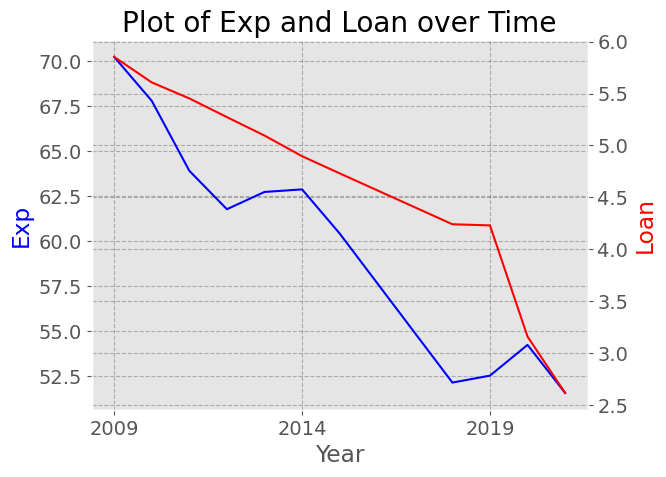

In [9]:
dp.plot_time(df);

The plot displays data for Denmark's municipalities on the expenditure per capita on library material and the number of books on loan per capita. Both variables exhibit a decreasing trend over the period studied indicating that Danish municipalities are spending less on books and lending fewer books per capita over time. However, it is not possible to determine whether the decrease in library expenditures per capita caused the decrease in loaned books per capita, or vice versa. Nonetheless, it is reasonable to expect that the decrease in expenditure caused the decrease in loaned books, since libraries with less funding may have fewer resources to purchase books and promote reading.

### 3.2. <a id='toc2_2_'></a>[Relation between books per capita and expenditure per capita](#toc0_)

**Scatter plot**


We now plot the relationship between the expenditure and the number of borrowed books in municipalities.

In [10]:
# Deleting the regions and the observations concerning all of Denmark as a whole, so as not to count observations twice.
df_mun = df[~df['mun'].str.startswith(('Region','All Denmark'))]

# Deleting municipalities with no library expenditures
df_2 = df=df_mun[df_mun['exp_per_cap'] > 1]


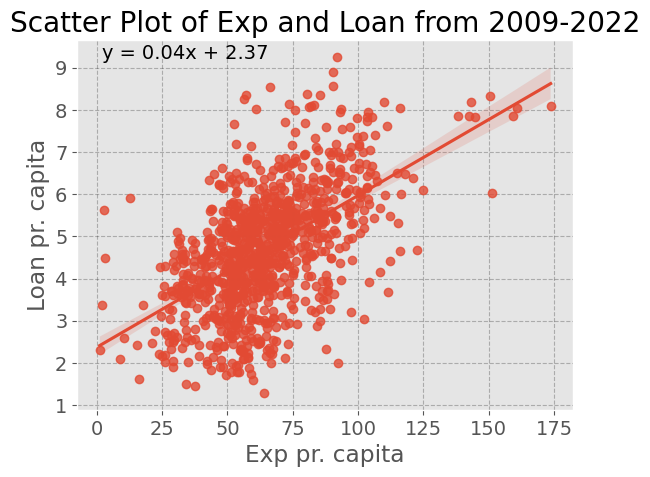

                            OLS Regression Results                            
Dep. Variable:           loan_per_cap   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     428.4
Date:                Tue, 23 May 2023   Prob (F-statistic):           2.47e-79
Time:                        09:57:55   Log-Likelihood:                -1575.6
No. Observations:                 990   AIC:                             3155.
Df Residuals:                     988   BIC:                             3165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3716      0.118     20.044      

In [11]:
dp.plot_scatter(df_2)

The table presents the OLS estimate for the linear regression model between expenditure on material per capita and the number of books borrowed per capita. 

The table shows a positive and statistically significant estimate for the coefficient for the expenditure per capita. The coefficient is 0.0360, which suggests that for an increase in exp. per capita of 1 DKK, the predicted loan of books per capita increases by 0.0360. If it was a causal relationship an increase in expenditure per capita of DKK 100 in a given municipalities would cause the average books borrowed per capita to increase by roughly 4 books, per year.


## 4. <a id='toc3_'></a>[Yearly comparison](#toc0_)

**Yearly scatter plot**


We now plot the yearly relationship between the expenditure and the number of borrowed books in municipalities.

In [12]:
# Dropdown menu for the years
def plot_timesseries(df_2):
    widgets.interact(dp.plot_year,
    df_2 = widgets.fixed(df_2),
    year = widgets.Dropdown(
        description='Year',
        options=df_2.year.unique(),
        value=df_2.year.unique()[0]),
);        
plot_timesseries(df_2)

interactive(children=(Dropdown(description='Year', options=('2009', '2010', '2011', '2012', '2013', '2014', '2…

c:\Users\mathi\Desktop\Kandidat i økonomi\1. Semester\Introduction to programming and numerical analysis\Assignments\projects-2023-mathias-emma-S-ren\dataproject\dataproject.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_mun['mun_match'] = df_2_mun['mun'].apply(lambda x: match_strings(x, denmark_map['mun']))
c:\Users\mathi\Desktop\Kandidat i økonomi\1. Semester\Introduction to programming and numerical analysis\Assignments\projects-2023-mathias-emma-S-ren\dataproject\dataproject.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

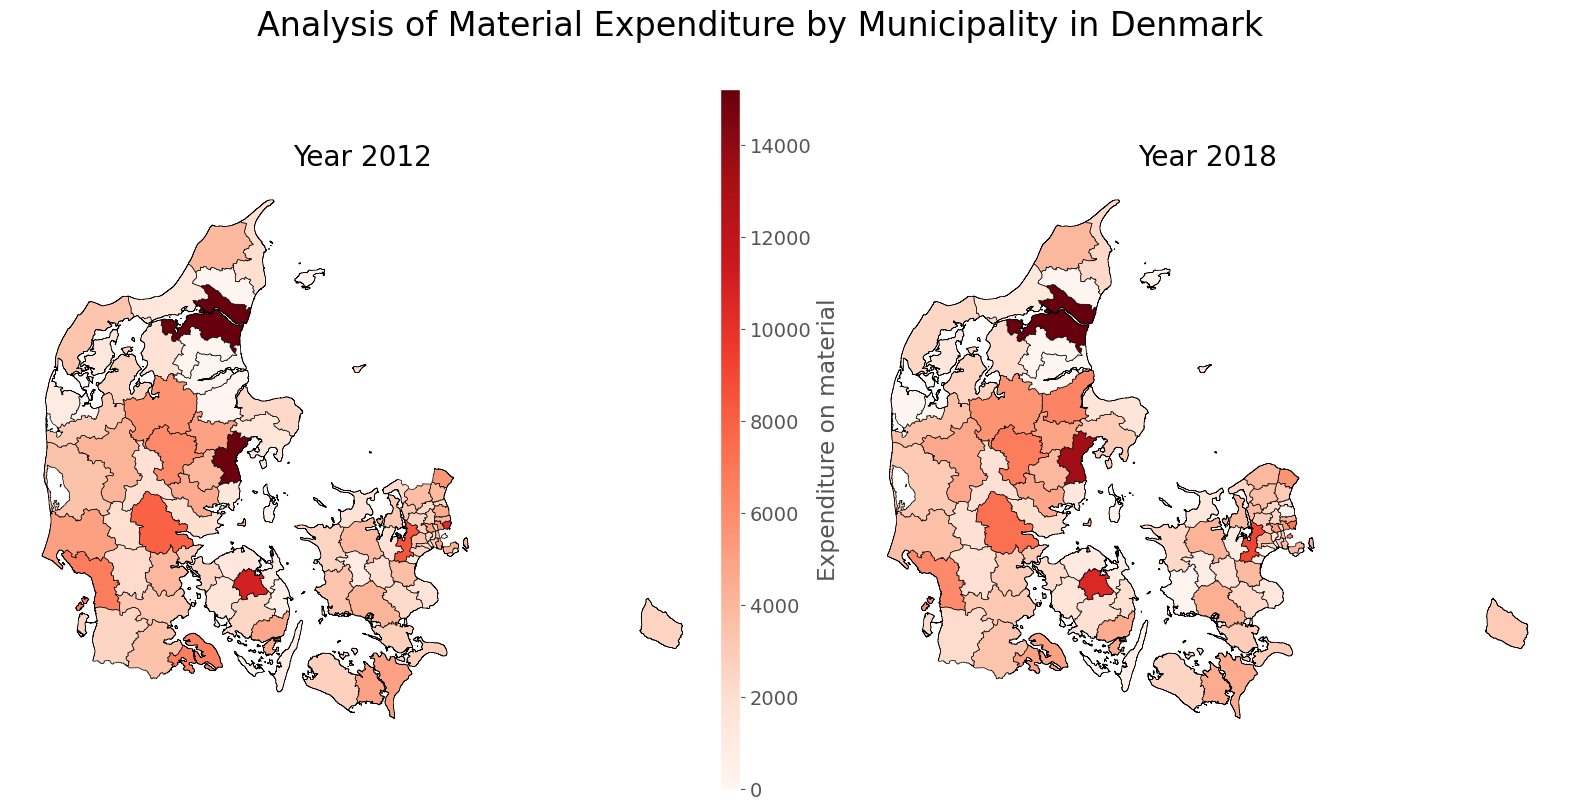

In [13]:
dp.map_plot(df_mun)

## Visualizing and Concluding Remarks 

This figure displays a geographical overview of material expenditure per capita across municipalities in Denmark for 2012 and 2018. The color scheme signifies the level of material expenditure per capita for the respective municipality, with darker shades representing higher levels of expenditure per capita and lighter shades representing lower levels.


We observe a relatively stable pattern of material expenditure across municipalities, suggesting the persistence of contributing factors over time. Notably, municipalities housing larger cities exhibit the highest expenditure per capita. This may reflect a number of factors such as the influence of universities and institutions, education and literacy rates, or perhaps greater resources.  

# Conclusion

In this study of library expenditure and book loans in Danish municipalities, we leveraged our data from Statistikbanken and conducted visual analyses. We observed a decreasing trend in both library expenditure and book loans from 2009 to 2022. Our regression analysis indicated a modest yet significant positive correlation between per capita expenditure and book loans. This suggests that an increase in expenditure per capita might predict a subsequent increase in book loans.


Moreover, we made a geographical examination of the expenditure level in each municipality. We found that the expenditure patterns remained stable over the time period, with municipalities of larger cities showing the highest expenditure per capita. These findings raise fundamental questions for further research in this field. In particular, it is crucial to analyze the factors contributing to the observed differences in library expenditure between urban and rural areas. Furthermore, it would be interesting to investigate the causes of the overall declining trend in the interest of books within the library sector.